# GPU Accelaration with CUDA
We have explored the purpose of gpu for accelarating an algorithm in the last blog, In this blog we are going to accelarate the mandelbrot set function from the last blog using gpu. If you haven't read the last blog [here](https://medium.com/infye/introduction-to-general-purpose-gpu-programming-1f5411837d86) is the link for that. In this blog we are going to explore the implementation of mandelbrot set with gpu accelaration. 

### Requirements :
#### Hardware requirements:
* Any GPU higher than 1050 Ti(gpu released after 1050Ti should work, code in this blog is tested with 1050 and 1650)

#### Software requirements:
* Any linux os(Tested in ubuntu 20.04 LTS)
* python3
* Pycuda
* matplotlib
* numpy

you can install the above packages with python pip. Pycuda requires cuda drivers to be installed, you can refer the instructions in this [page](https://documen.tician.de/pycuda/) for cuda driver installation. Before getting into gpu programming we'll first detect the type of the cpu and gpu we are using. [Here] is the colab link for this blog

In [2]:
!lscpu 

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   43 bits physical, 48 bits virtual
CPU(s):                          8
On-line CPU(s) list:             0-7
Thread(s) per core:              2
Core(s) per socket:              4
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       AuthenticAMD
CPU family:                      23
Model:                           24
Model name:                      AMD Ryzen 5 3550H with Radeon Vega Mobile Gfx
Stepping:                        1
Frequency boost:                 enabled
CPU MHz:                         1361.948
CPU max MHz:                     2100.0000
CPU min MHz:                     1400.0000
BogoMIPS:                        4192.45
Virtualization:                  AMD-V
L1d cache:                       128 KiB
L1i cache:                       256 KiB
L2 cache:              

The above command shows the type of cpu we are using. I have an AMD Ryzen5 3550H processor which is a 64bit computer. We can see the maximum and minimum clock speed of the cpu and cpu count or number of cores which is 8. The above command shows the general specifications of a cpu now we can see the gpu attached with our cpu.

In [3]:
!lspci | grep -e "NVIDIA"

01:00.0 VGA compatible controller: NVIDIA Corporation TU117M [GeForce GTX 1650 Mobile / Max-Q] (rev a1)
01:00.1 Audio device: NVIDIA Corporation Device 10fa (rev a1)


In the above command we have listed the PCI bus in the computer and used grep command to search the nvidia gpu. Why we have listed the pci bus? , because the gpu in our computer is connected with our computer through PCI bus, you can learn more about PCI bus in this [link](https://www.ovh.com/blog/how-pci-express-works-and-why-you-should-care-gpu/). Now we can see the gpu model which is GTX 1650 which is connected with the computer. Now we can install pycuda.


In [4]:
!pip3 install pycuda

You should consider upgrading via the '/home/cvr/playground/cuda-gpu/Hands-On-GPU-Programming-with-Python-and-CUDA/env/bin/python3.7 -m pip install --upgrade pip' command.


After installing pycuda we can test the installation.

In [5]:
import pycuda.driver as drv # 1
drv.init() # 2
print("No of GPUs attached :",drv.Device.count()) #3
gpu = drv.Device(0) # 4
print("GPU name :",gpu.name()) # 5
print("GPU memory : ",gpu.total_memory()/1024**2) # 6
gpu_attributes = gpu.get_attributes().items() # 6
for k,v in gpu_attributes:
    print(k,v)


No of GPUs attached : 1
GPU name : GeForce GTX 1650
GPU memory :  3911.875
ASYNC_ENGINE_COUNT 3
CAN_MAP_HOST_MEMORY 1
CLOCK_RATE 1560000
COMPUTE_CAPABILITY_MAJOR 7
COMPUTE_CAPABILITY_MINOR 5
COMPUTE_MODE DEFAULT
CONCURRENT_KERNELS 1
ECC_ENABLED 0
GLOBAL_L1_CACHE_SUPPORTED 1
GLOBAL_MEMORY_BUS_WIDTH 128
GPU_OVERLAP 1
INTEGRATED 0
KERNEL_EXEC_TIMEOUT 1
L2_CACHE_SIZE 1048576
LOCAL_L1_CACHE_SUPPORTED 1
MANAGED_MEMORY 1
MAXIMUM_SURFACE1D_LAYERED_LAYERS 2048
MAXIMUM_SURFACE1D_LAYERED_WIDTH 32768
MAXIMUM_SURFACE1D_WIDTH 32768
MAXIMUM_SURFACE2D_HEIGHT 65536
MAXIMUM_SURFACE2D_LAYERED_HEIGHT 32768
MAXIMUM_SURFACE2D_LAYERED_LAYERS 2048
MAXIMUM_SURFACE2D_LAYERED_WIDTH 32768
MAXIMUM_SURFACE2D_WIDTH 131072
MAXIMUM_SURFACE3D_DEPTH 16384
MAXIMUM_SURFACE3D_HEIGHT 16384
MAXIMUM_SURFACE3D_WIDTH 16384
MAXIMUM_SURFACECUBEMAP_LAYERED_LAYERS 2046
MAXIMUM_SURFACECUBEMAP_LAYERED_WIDTH 32768
MAXIMUM_SURFACECUBEMAP_WIDTH 32768
MAXIMUM_TEXTURE1D_LAYERED_LAYERS 2048
MAXIMUM_TEXTURE1D_LAYERED_WIDTH 32768
MAXIMUM_TEX

There is a lot of information lying in the above command, I'll try to decode the important ones. First we'll import the pycuda and initialise the package.Then we'll print number of gpu's attached with the computer which is one in this case, then we have printed the name of the gpu and gpu memory in MB. Here we refer primary gpu memory or gpu RAM as memory. Then we have printed the attributes of gpu which includes the details such as gpu clock speed , multiprocessor count , compute capability , memory clock rate etc. Another important attribute is no of cores in the gpu. A GPU divides its individual cores up into larger units known as Streaming Multiprocessors (SMs). In our case GTX 1650 gpu has 16 SM and 1024 cores. We calculate the number of cores with something called as compute capablilty of the gpu, you can explore more on compute capability [here](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#compute-capability) . We'll revisit mandelbrot set now.

In [6]:
from time import time # 1
from matplotlib import pyplot as plt # 2
import numpy as np # 3 
import pycuda.autoinit
from pycuda import gpuarray # 4
from pycuda.elementwise import ElementwiseKernel # 5


* we have imported the time module in python to calculate the run time of the algorithm.
* In second line we have imported the matplotlib for ploting the graph.
* We have imported the numpy in third line.
* We have imported the gpuarray in line four which is similar to numpy array object with gpu accelaration capability.
* In fifth line we have imported Elementwisekernel of pycuda. In cuda we refer a parallel function as kernel and the elementwisekernel is used for inplace array operations or individual value manipulation in an array. There are many kerrnel function in cuda which we'll explore in upcoming blogs. 

In [7]:
mandel_ker = ElementwiseKernel(
"pycuda::complex<float> *lattice, float *mandelbrot_graph, int max_iters, float upper_bound",
"""
mandelbrot_graph[i] = 1;

pycuda::complex<float> c = lattice[i]; 
pycuda::complex<float> z(0,0);

for (int j = 0; j < max_iters; j++)
    {
    
     z = z*z + c;
     
     if(abs(z) > upper_bound)
         {
          mandelbrot_graph[i] = 0;
          break;
         }

    }
         
""",
"mandel_ker")

We have initialised the elementwisekernel above.
* We have difined the input and output of the kernel which is lattice and mandelbrot_graph.
* Then we have max_iters for number of iteration in mandelbrot set and upper_bound parameter.
* The ElementwiseKernel object has two parametes one is cuda function and another one is name of the kernel which is mandel_ker.
* We can see that the pycuda function declaration is done in first line with single quotation and definition in done with triple quotation. In cuda we can write multilined statements with triple quotation.

In [8]:
def gpu_mandelbrot(width, height, real_low, real_high, imag_low, imag_high, max_iters, upper_bound):

    # we set up our complex lattice as such
    real_vals = np.matrix(np.linspace(real_low, real_high, width), dtype=np.complex64) # 1
    imag_vals = np.matrix(np.linspace( imag_high, imag_low, height), dtype=np.complex64) * 1j
    mandelbrot_lattice = np.array(real_vals + imag_vals.transpose(), dtype=np.complex64) # 2 
    
    # copy complex lattice to the GPU
    mandelbrot_lattice_gpu = gpuarray.to_gpu(mandelbrot_lattice) # 3

    # allocate an empty array on the GPU
    mandelbrot_graph_gpu = gpuarray.empty(shape=mandelbrot_lattice.shape, dtype=np.float32) # 4

    mandel_ker( mandelbrot_lattice_gpu, mandelbrot_graph_gpu, np.int32(max_iters), np.float32(upper_bound)) # 5
              
    mandelbrot_graph = mandelbrot_graph_gpu.get() # 6
    
    return mandelbrot_graph 

We have defined the method which would calculate mandelbrot set by calling cuda kernel
* We have created an lattice/matrix of  complex numbers in (1)
* Then we have converted the lattice to a numpy array in (2)
* In (3) we have copied the data from host(computer) memory to device(gpu) memory.
* In (4) we have created an empty gpu array to store the returned array from ElementwiseKernel.
* In (5) we have called mandel_ker with mandelbrot_lattice_gpu , mandelbrot_graph_gpu , max_iters and upper_bound.
    we can see max_iters and upper_bound is type casted before passing to ElementwiseKernel , This is because we write gpu kernels in c programming language which is a statically-typed language so we should initialise the varibles with type. So we have strictly followed C lang prnciples and type casted the values before passing to function. Inside the kernel we have lattice and mandelbrot_graph as pointers , max_iters and upper_bound as normal variables , this is because we can only pass array as pointers to kernel and we can pass normal variable as just values or pointers. Inside the kernel function we have declare the lattice as complex datatype which is equivalent to numpy.complex64 type and we have initialised the output as one. We can see the "i" in initilisation of mandelbrot_graph which is not defined (mandelbrot_graph[i] = 1), this is because as we said earlier iteration of "i"  variable is automatically taken care by cuda( cuda will parallise the variable "i" automatically) so that we can initialise "i". Then we have declared an variable z of same type complex and then we have computed the mandelbrot set and stored the value in mandelbrot_graph( output variable). We can see that we have assigned **'c'** as **'lattice[i]'** , as we have seen before that the variable **"i"** will be automatically parallised so we have only used one for loop compared to the mandelbrot set which we saw in previous blog. In this example we have passed the input **'lattice'** as array so we have used only one for loop.


* After computing the mandelbrot set we moved back the data from gpu memory to cpu memory with .get() method in (6).


It took 0.2567741870880127 seconds to calculate the Mandelbrot graph.
It took 0.023880720138549805 seconds to dump the image.


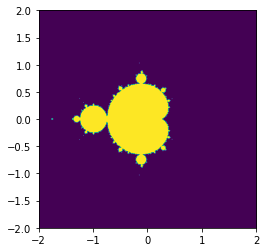

In [9]:
t1 = time()
mandel = gpu_mandelbrot(512,512,-2,2,-2,2,512, 2)
t2 = time()

mandel_time = t2 - t1

t1 = time()
fig = plt.figure(1)
plt.imshow(mandel, extent=(-2, 2, -2, 2))
#plt.savefig('mandelbrot.png', dpi=fig.dpi)
t2 = time()

dump_time = t2 - t1

print ('It took {} seconds to calculate the Mandelbrot graph.'.format(mandel_time))
print ('It took {} seconds to dump the image.'.format(dump_time))

In this script we have calcualted the time taken for Mandelbrot set calculation and graph generation.
It took 0.2 second for Mandelbrot set calculations and 0.03 second for graph generation , which is very fast compared to cpu computation which is 14 second( which we calcualted in the previous blog). 